# Deep Learning for the Geosciences (Technion 16837)

## Assignment #4a: CIFAR-10 Revisited

In [10]:
import numpy as np # Importing the numpy package to perform calculations
import matplotlib.pyplot as plt # Importing the pyplot package to plot data
import sys
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
# import tqdm
# import optuna
# import pandas as pd
# import os

%matplotlib inline

# Import local files
sys.path.append('code')
from model import *
from train import *
from utils import *

# Do not change below! Important for reloading code you write in external .py files.
%load_ext autoreload 
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## <ins>Note about chatGPT </ins>
As always, you may use chatGPT to complete your assignments, if you indicate you did. However, since our goal here is not only to get a good grade - but also to learn something - I recommend that you first attempt to solve the assignment yourself and only then look at what ChatGPT has to offer. 

When choosing to use ChatGPT:
1. Please write your input prompt.
2. Try to understand the code instead of just copying it.
3. Explain the code in words. What does each line do? What is the expected input and output?

Important note: Failing to disclose the use of ChatGPT or similar AI tools in an assignment may lead to the loss of all points for the assignment.

---

## 1. <ins>Download the CIFAR-10 data</ins>
This is similar to what we have done in homework 2.

In [4]:
# Parameters 
train_batch_size = 16
test_batch_size = 16

In [5]:


# Setting a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Downloading the CIFAR-10 datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Splitting the training set for validation
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))  # 10% for validation

np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Creating DataLoaders for training, validation, and test sets
trainloader = DataLoader(trainset, batch_size=train_batch_size, sampler=train_sampler, num_workers=2)
validloader = DataLoader(trainset, batch_size=train_batch_size, sampler=valid_sampler, num_workers=2)
testloader = DataLoader(testset, batch_size=test_batch_size, shuffle=True, num_workers=2)

# Classes in the CIFAR-10 Dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 2. <ins>Train the basic neural network on the CIFAR-10 data</ins>
CNNs in Pytorch are defined as Python classes. To implement a custom model (CNN), you need to implement the class constructor (`__init__(self)`) and the `forward(self, x)` method, which performs forward propagation. Compare the `basic_cnn()` class to what we have done in the last workshop.

The `basic_cnn` convolutional neural network is already implemented. Run it below and observe how it performs. Note: running this CNN for 10 epochs takes about 10-15 minutes on a modern laptop with no GPU.

In [36]:
model = Basic_cnn()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epoch_losses, epoch_val_losses = train_network(model, trainloader, validloader, optimizer, epochs=10)

Training model...
Epoch 1/10 - Validation Batch 313/313
Epoch 1/10, Training Loss: 1.575, Validation Loss: 1.376
Epoch 2/10 - Validation Batch 313/313
Epoch 2/10, Training Loss: 1.270, Validation Loss: 1.267
Epoch 3/10 - Validation Batch 313/313
Epoch 3/10, Training Loss: 1.145, Validation Loss: 1.165
Epoch 4/10 - Validation Batch 313/313
Epoch 4/10, Training Loss: 1.075, Validation Loss: 1.158
Epoch 5/10 - Validation Batch 313/313
Epoch 5/10, Training Loss: 1.024, Validation Loss: 1.106
Epoch 6/10 - Validation Batch 313/313
Epoch 6/10, Training Loss: 0.993, Validation Loss: 1.111
Epoch 7/10 - Validation Batch 313/313
Epoch 7/10, Training Loss: 0.969, Validation Loss: 1.106
Epoch 8/10 - Validation Batch 313/313
Epoch 8/10, Training Loss: 0.950, Validation Loss: 1.137
Epoch 9/10 - Validation Batch 313/313
Epoch 9/10, Training Loss: 0.932, Validation Loss: 1.081
Epoch 10/10 - Validation Batch 313/313
Epoch 10/10, Training Loss: 0.917, Validation Loss: 1.120
Finished Training


### Plot the model loss
You can change the hyperparameters (learning rate and momentum or type of optimizer) and see how the loss changes.

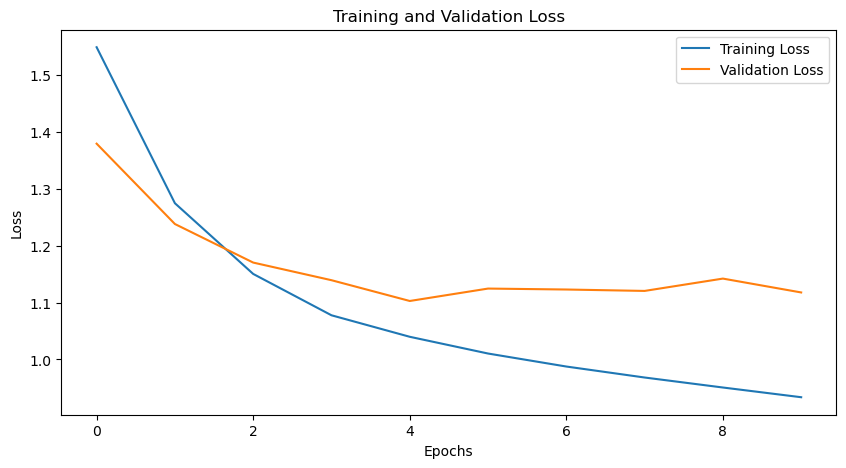

In [6]:
plot_training_validation_loss(epoch_losses, epoch_val_losses)

## Precision, Recall and F1 score
As we have seen in class, precision and recall metrics for evaluating the performance of a classification model, especially in scenarios where the balance between false positives and false negatives is crucial. Precision measures the accuracy of positive predictions made by the model, calculated as the ratio of true positives to the sum of true and false positives. Recall, on the other hand, assesses the model's ability to identify all relevant instances, computed as the ratio of true positives to the sum of true positives and false negatives.

The F1 score is the harmonic mean of precision and recall, offering a single metric that balances the two by penalizing extreme values. 

$$ F1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} \ $$

Implement the `calculate_precision()` and `calculate_recall()` functions in `utils.py` before running the next cells.

In [7]:
accuracy = calculate_accuracy(model, testloader)
print(f'Accuracy of the model on the test images: {accuracy}%')

Accuracy of the model on the test images: 62.48%


In [13]:
def calculateTP_FP_FN(model, dataloader):
    correct = [0]*10
    false_positives = [0]*10
    false_negatives = [0]*10
    total = [0] * 10
    with torch.no_grad():  # No need to calculate gradients
        for data in dataloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(10):
                total[i] += (labels == i).sum().item()
                correct[i] += ((predicted == i) & (labels == i)).sum().item()
                false_positives[i] += ((predicted == i) & (labels != i)).sum().item()
                false_negatives[i] += ((predicted != i) & (labels == i)).sum().item()
            
    true_positives = [correct[i] / total[i] if total[i] != 0 else 0 for i in range(10)]
    false_positives = [false_positives[i] / total[i] if total[i] != 0 else 0 for i in range(10)]
    false_negatives = [false_negatives[i] / total[i] if total[i] != 0 else 0 for i in range(10)]
    return true_positives, false_positives, false_negatives

In [8]:

###
# COMPLETE THE CODE BELOW.
# Hint: You will need to compute the number of true positives, false positives and false negatives. Take a look at the implementation of calculate_accuracy() for inspiration.
#
###


true_positives, false_positives, false_negatives = calculateTP_FP_FN(model, testloader)
print("test true positives")
print(true_positives)
print("test false positives")
print(false_positives)
print("test false negatives")
print(false_negatives)

precision = calculate_precision(true_positives, false_positives)
print("test precision")
print(precision)
recall = calculate_recall(true_positives, false_negatives)
print("test recall")
print(recall)
f1 = calculate_f1_score(precision, recall)
print("test f1")
print(f1)

###

test true positives
[0.641, 0.811, 0.574, 0.33, 0.552, 0.589, 0.683, 0.738, 0.712, 0.618]
test false positives
[0.326, 0.386, 0.746, 0.318, 0.425, 0.516, 0.232, 0.407, 0.217, 0.179]
test false negatives
[0.359, 0.189, 0.426, 0.67, 0.448, 0.411, 0.317, 0.262, 0.288, 0.382]
test precision
[0.663, 0.678, 0.435, 0.509, 0.565, 0.533, 0.746, 0.645, 0.766, 0.775]
test recall
[0.641, 0.811, 0.574, 0.33, 0.552, 0.589, 0.683, 0.738, 0.712, 0.618]
test f1
([0.652, 0.739, 0.495, 0.4, 0.558, 0.56, 0.713, 0.688, 0.738, 0.688], 0.6230999999999999)


## Show a few predictions with their corresponding labels

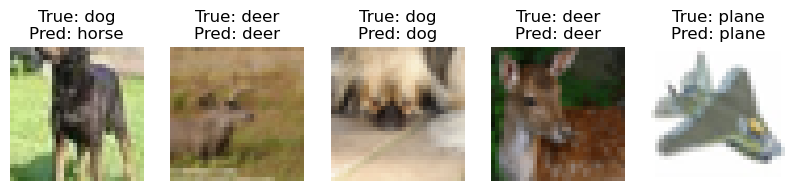

In [29]:
# Get a single batch of images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Model's prediction
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Randomly sample images and their corresponding labels and predictions
num_samples = test_batch_size  # Number of samples to display
indices = torch.randperm(len(images))[:5]

# Display random samples
random_images = images[indices]
random_labels = labels[indices]
random_predicted = predicted[indices]

draw_imgs_labels(random_images, random_labels, random_predicted, classes)

### Visualize the output layer templates
Similar to our SVM implementation, we can visualize the feature maps produced by the output layer of the CNN. Use the code below to do that.

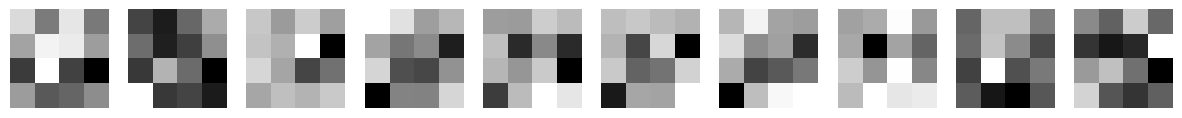

In [24]:
def visualize_feature_maps(feature_maps):
    fig, axs = plt.subplots(1, feature_maps.size(1), figsize=(15, 15))
    for i, ax in enumerate(axs):
        ax.imshow(feature_maps[:, i].detach().numpy().reshape((4,4)), cmap='gray')
        ax.axis('off')
    plt.show()

# Load one of the CIFAR-10 images in the next line:
images, _ = next(iter(testloader))
image = images
# plt.imshow(image.detach().numpy())
output_feature_map = model(image)
# plt.imshow(output_feature_map.detach().numpy())
output_feature_map[0,0]
visualize_feature_maps(output_feature_map)

***
## <font color='lightgreen'>Answer the following questions</font>
1. Explain your training loss and validation loss graphs.
2. How did the accuracy change compared to the SVM classifier we trained in Homework 2? Why?
3. Change the training batch size to 4, 8, 16, 32, 64, and plot the final loss or accuracy as a function of the batch size. How does the accuracy/final loss change with the batch size? Why?
4. Change the optimizer to Adam. How does that affect training time? How does that affect the accuracy? Why, in your opinion, does the accuracy depend on the choice of the optimizer? When will using a "better" optimizer have an adverse effect on the training accuracy?
5. When visualizing the output layer's filters above, what do you see? Compare your results with the templates of the SVM algorithm. Are they the same? What is different? Why in your opinion is there a difference?
***

1. ניתן לראות בגרפים של האימון והבדיקה כי לאחר מספר איטרציות מתחיל להיווצר התאמת יתר לנתוני האימון. תחילה אנחנו רואים ירידה בשני הגרפים אחר לאחר מספר איטרציות הירידה מתקבלת רק עבור נתוני האימון ולא עבור נתוני הבדיקה.
2. בשונה מהתוצאות של SVM בתרגיל זה קיבלתי דיוק של כ60 אחוז. ניתן להניח כי שיפור זה נובע בגלל האי לינאריות של המודל שלנו. אני מאמין שעם התאמה יותר טובה של ההיפר פרמטרים ואלי סיבוך נוסף של המודל (הוספת שכבות למשל) ניתן אםילו להגיע לדיוקים גובהים יותר.
3. בהמשך
4. בהמשך
5. ניתן לראות שבשונה מהSVM כאן אנחנו מקבלים תמונות אמורפיות שלא ניתן לזהות בהם שום דבר. המודל הנ"ל מורכב יותר ומוצא פיצרים שלא ניתנים לתיאור מילולי.

In [ ]:
#Q3
Accurasies = []
for bs in [4,8,16,32,64]:
    trainloader = DataLoader(trainset, batch_size=bs, sampler=train_sampler, num_workers=2)
    validloader = DataLoader(trainset, batch_size=bs, sampler=valid_sampler, num_workers=2)

    model = Basic_cnn()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    epoch_losses, epoch_val_losses = train_network(model, trainloader, validloader, optimizer, epochs=10)
    accuracy = calculate_accuracy(model, testloader)
    Accurasies.append(accuracy)

plt.plot([4,8,16,32,64], Accurasies)
    

Training model...
Epoch 1/10 - Training Batch 10840/11250

נראה שתחילה הדיוק גדל ככל שמגדילים את גודל החלק אך יש נקודה שממנה הדיוק קטן. אני מעריך שהדיוק קטן כי אמנם כל איטרציה אנחנו מחשבים על יותר תמונות אך בפועל אנחנו מחשבים פחות פעמים את הגודל של הגרדיאנט ולכן בפועל מחשבים פחות איטרציות.

In [13]:
#Q4
trainloader = DataLoader(trainset, batch_size=16, sampler=train_sampler, num_workers=2)
validloader = DataLoader(trainset, batch_size=16, sampler=valid_sampler, num_workers=2)

model = Basic_cnn()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epoch_losses, epoch_val_losses = train_network(model, trainloader, validloader, optimizer, epochs=10)
accuracy = calculate_accuracy(model, testloader)



Training model...
Epoch 1/10 - Validation Batch 313/313
Epoch 1/10, Training Loss: 1.430, Validation Loss: 1.292
Epoch 2/10 - Validation Batch 313/313
Epoch 2/10, Training Loss: 1.179, Validation Loss: 1.244
Epoch 3/10 - Validation Batch 313/313
Epoch 3/10, Training Loss: 1.092, Validation Loss: 1.168
Epoch 4/10 - Validation Batch 313/313
Epoch 4/10, Training Loss: 1.044, Validation Loss: 1.135
Epoch 5/10 - Validation Batch 313/313
Epoch 5/10, Training Loss: 1.008, Validation Loss: 1.176
Epoch 6/10 - Validation Batch 313/313
Epoch 6/10, Training Loss: 0.982, Validation Loss: 1.189
Epoch 7/10 - Validation Batch 313/313
Epoch 7/10, Training Loss: 0.966, Validation Loss: 1.163
Epoch 8/10 - Validation Batch 313/313
Epoch 8/10, Training Loss: 0.942, Validation Loss: 1.201
Epoch 9/10 - Validation Batch 313/313
Epoch 9/10, Training Loss: 0.931, Validation Loss: 1.220
Epoch 10/10 - Validation Batch 313/313
Epoch 10/10, Training Loss: 0.911, Validation Loss: 1.170
Finished Training


In [14]:
print(accuracy)

61.33


נראה שהדיוק וזמן הריצה לא מאוד השתנו. בחירת אלגוריתם האופטימיזציה חשוב לדיוק בשל החשיבות של קביעת צעד הלמידה בכל שלב. עבור פונציה עם מספר מינימום מקומיים בחירה נכונה של אלגוריתם זה יכולה להשפיע על הצלחה או אי הצלחה של האימון.

## 3. <ins>Outperform the F1 score of the basic neural netowork by implementing your own</ins>
Implement the Better_cnn() class, taking inspiration from the Basic_cnn() class.

In [11]:
model = Better_cnn(128, 516)

# model = Better_cnn(8, 4)

# trainloader = DataLoader(trainset, batch_size=16, sampler=train_sampler, num_workers=2)
# validloader = DataLoader(trainset, batch_size=16, sampler=valid_sampler, num_workers=2)

# for i, (inputs, labels) in enumerate(trainloader):
#      print(inputs.size())
#      print(labels.size())


# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0004, nesterov=True)
epoch_losses, epoch_val_losses = train_network(model, trainloader, validloader, optimizer, epochs=10)


Training model...
Epoch 1/10 - Validation Batch 313/313
Epoch 1/10, Training Loss: 1.353, Validation Loss: 1.148
Epoch 2/10 - Validation Batch 313/313
Epoch 2/10, Training Loss: 1.033, Validation Loss: 1.027
Epoch 3/10 - Validation Batch 313/313
Epoch 3/10, Training Loss: 0.904, Validation Loss: 0.923
Epoch 4/10 - Validation Batch 313/313
Epoch 4/10, Training Loss: 0.813, Validation Loss: 0.883
Epoch 5/10 - Validation Batch 313/313
Epoch 5/10, Training Loss: 0.743, Validation Loss: 0.829
Epoch 6/10 - Validation Batch 313/313
Epoch 6/10, Training Loss: 0.683, Validation Loss: 0.820
Epoch 7/10 - Validation Batch 313/313
Epoch 7/10, Training Loss: 0.630, Validation Loss: 0.792
Epoch 8/10 - Validation Batch 313/313
Epoch 8/10, Training Loss: 0.580, Validation Loss: 0.785
Epoch 9/10 - Validation Batch 313/313
Epoch 9/10, Training Loss: 0.533, Validation Loss: 0.764
Epoch 10/10 - Validation Batch 313/313
Epoch 10/10, Training Loss: 0.493, Validation Loss: 0.761
Finished Training


### Plot the model loss

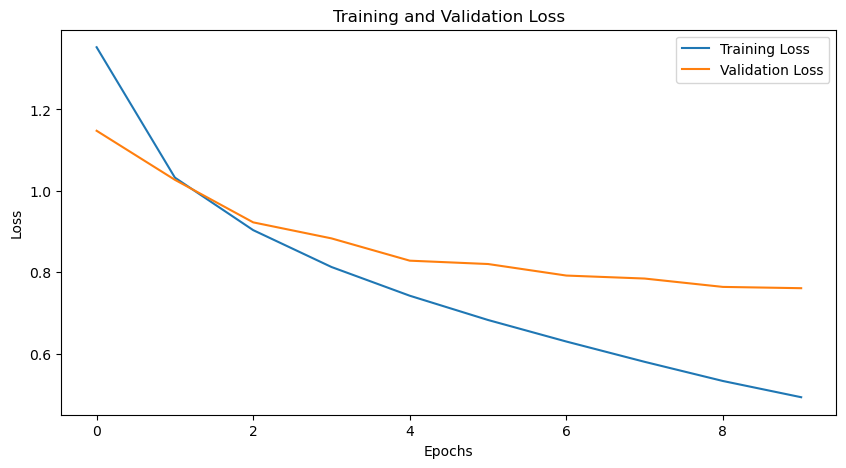

In [12]:
plot_training_validation_loss(epoch_losses, epoch_val_losses)

In [14]:
accuracy = calculate_accuracy(model, testloader)
print(f'Accuracy of the model on the test images: {accuracy}%')

###
true_positives, false_positives, false_negatives = calculateTP_FP_FN(model, testloader)
precision = calculate_precision(true_positives, false_positives)
recall = calculate_recall(true_positives, false_negatives)
f1 = calculate_f1_score(precision, recall)
print("test f1")
print(f1)
# Use the code you wrote above to compute the F-1 score of Better_CNN()
###

Accuracy of the model on the test images: 74.42%
test f1
([0.777, 0.836, 0.658, 0.57, 0.703, 0.638, 0.811, 0.789, 0.839, 0.816], 0.7437)


In [ ]:
# Get a single batch of images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Model's prediction
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Randomly sample images and their corresponding labels and predictions
num_samples = test_batch_size  # Number of samples to display
indices = torch.randperm(len(images))[:5]

# Display random samples
random_images = images[indices]
random_labels = labels[indices]
random_predicted = predicted[indices]

draw_imgs_labels(random_images, random_labels, random_predicted, classes)

***
## <font color='lightgreen'>Answer the following questions</font>
1. Adjust the model until it achieves 80% accuracy in 10 epoches or less. Try different hyperparameters, layers and regularization methods.
2. Print and explain the structure(layers) of your neural network. Note: you cannot use ChatGPT (or any other large language model) to do this task. Even if you used chatGPT (or one of its amigos) to write code, you have to explain the neural network in your own words.
3. Identify the layer that had the greatest positive effect on the accuracy. Hint: you do not have to train the entire network over all epochs! Why do you think it influenced the most?
***

1. אחרי הרבה נסיונות (מצורף אקסל עם ההרצות השונות) הדיוק הגבוה ביותר שהגעתי אליו הוא 73%. בנוסף לאקסל ניסיתי מספר רשתוות עם שלוש וארבע שכבות קונבולוציה ועדיין לא הגעתי לדיוק טוב יותר.
2. הסבר על הרשת מצורף במסמך נפרד
3. לא היה לי זמן לענות על השאלה, דורש הרבה שינויים במבנה של המודל מבחינת הגדלים שמקבלים אם מורידים חלק מסויים. מקווה שזה לא יוריד יותר מידי נקודות.

## 4. ResNet and Transfer Learning


ResNet is a convolutional neural network that uses skip connections to improve performance. As the basis (backbone) for many object detection convolutional neural networks, ResNet is one of the most widely used CNNs. The complexity of a ResNet neural network can be determined by the number that follows the CNN name. For example, ResNet-18 has 18 layers compared to the more complicated ResNet-101 which has 101 layers. More complex models can determine more complex and non-linear patterns in data.

ResNet was trained on ImageNet, a large dataset of classified images. ImageNet has more than 10 classes (like CIFAR-10 has), so to use transfer learning we would need to adjust the output layer of ResNet to match the number of classes in CIFAR-10.

In this assignment, you will train different versions of ResNet on the CIFAR-10 dataset and compare them to the neural network you developed above.

### 4a. Pretrained ResNet-18

Download ResNet-18 previously trained on ImageNet data:

In [35]:
# Download pre-trained ResNet 18 (18 layers)
resnet18 = models.resnet18(pretrained=True)

# Modify the last fully connected layer (fc) for CIFAR-10. We need to do this as ResNet was pretrained on ImageNet, which has more classes.
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10) 

# Use the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

C:\Users\DELL\anaconda33\envs\HW4_amen\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\anaconda33\envs\HW4_amen\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\DELL/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:18<00:00, 2.51MB/s]


Evaluate ResNet-18 on the CIFAR-10 dataset:

In [36]:
resnet18.eval()  # Set the model to evaluation mode
criterion = nn.CrossEntropyLoss()

correct = 0
total = 0
running_loss = 0.0

with torch.no_grad():  # As we have seen in the workshop, inference doesn't require gradients; this is set using the no_grad function.
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the ResNet18 on CIFAR-10 test images: {100 * correct / total}%')
print(f'Average loss: {running_loss / len(testloader)}')

Accuracy of the ResNet18 on CIFAR-10 test images: 9.31%
Average loss: 2.378617398452759


### 4b. Transfer learning with ResNet-18

Now, we will use transfer learning and tune ResNet by training it on the CIFAR-10 database. This should improve performance.

To use transfer learning, we will "freeze" the weights of the first layers of ResNet; when training, only the weights of the last layers in the network (which are used to detect abstract features) will change. This will guarantee the network still remembers its training on ImageNet for basic features like edges, lines and circles but becomes expert in detecting CIFAR-10 images.

Train the network using transfer learning by running the cell below. Training might take a little time on cpu; but do not change the number of epoches.

In [38]:
# Define optimizer for the newly added final layer
optimizer = torch.optim.Adam(resnet18.fc.parameters(), lr=0.001)

# Assuming trainloader and validloader are already defined and loaded with CIFAR-10
epoch_losses, epoch_val_losses = train_network(resnet18, trainloader, validloader, optimizer, epochs=10)

Training model...
Epoch 1/10 - Validation Batch 313/313
Epoch 1/10, Training Loss: 1.783, Validation Loss: 1.791
Epoch 2/10 - Validation Batch 313/313
Epoch 2/10, Training Loss: 1.725, Validation Loss: 1.732
Epoch 3/10 - Validation Batch 313/313
Epoch 3/10, Training Loss: 1.717, Validation Loss: 1.730
Epoch 4/10 - Validation Batch 313/313
Epoch 4/10, Training Loss: 1.720, Validation Loss: 1.721
Epoch 5/10 - Validation Batch 313/313
Epoch 5/10, Training Loss: 1.715, Validation Loss: 1.722
Epoch 6/10 - Validation Batch 313/313
Epoch 6/10, Training Loss: 1.711, Validation Loss: 1.738
Epoch 7/10 - Validation Batch 313/313
Epoch 7/10, Training Loss: 1.718, Validation Loss: 1.710
Epoch 8/10 - Validation Batch 313/313
Epoch 8/10, Training Loss: 1.718, Validation Loss: 1.732
Epoch 9/10 - Validation Batch 313/313
Epoch 9/10, Training Loss: 1.724, Validation Loss: 1.746
Epoch 10/10 - Validation Batch 313/313
Epoch 10/10, Training Loss: 1.714, Validation Loss: 1.690
Finished Training


In [39]:
resnet18.eval()  # Set the model to evaluation mode

correct = 0
total = 0
with torch.no_grad(): # As we have seen in the workshop, inference doesn't require gradients; this is set using the no_grad function.
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the ResNet18 on CIFAR-10 test images after transfer learning: {100 * correct / total}%')


Accuracy of the ResNet18 on CIFAR-10 test images after transfer learning: 43.18%


### 4b. ResNet-101
ResNet 101 is a residual neural network pre-trained on the ImageNet databse, with 101 layers.

In [41]:
# Download pre-trained ResNet 101
resnet101 = models.resnet101(pretrained=True)

# Modify the last fully connected layer (fc) for CIFAR-10. We need to do this as ResNet was pretrained on ImageNet, which has more classes.
num_ftrs = resnet101.fc.in_features
resnet101.fc = nn.Linear(num_ftrs, 10)

# Use the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet101 = resnet101.to(device)

C:\Users\DELL\anaconda33\envs\HW4_amen\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\DELL/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100%|████████████████████████████████████████████████████████████████████████████████| 171M/171M [03:50<00:00, 776kB/s]


In [42]:
resnet101.eval()  # Set the model to evaluation mode
criterion = nn.CrossEntropyLoss()

correct = 0
total = 0
running_loss = 0.0

with torch.no_grad():  # As we have seen in the workshop, inference doesn't require gradients; this is set using the no_grad function.
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet101(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the ResNet101 on CIFAR-10 test images: {100 * correct / total}%')
print(f'Average loss: {running_loss / len(testloader)}')

Accuracy of the ResNet101 on CIFAR-10 test images: 12.29%
Average loss: 2.5375401529312134


***
## <font color='lightgreen'>Answer the following questions</font>
1. What happened to the training accuracy when you used transfer learning with ResNet-18? Why do you think this is the case?
2. Which network performed best on CIFAR-10? Was it the pretrained ResNet-18, transfer-learned ResNet-18 or ResNet-101? Is that what you would expect? Explain.

1. בדומה לציפייה שלי, לפני שאימנתי את המודל על התמונות שלי הדיוק של הסיווג היה מאוד נמוך (פחות מ10 אחוז). לאחר האימון אשר אמור להתאים את המודל לתמונות שלנו קיבלנו תוצאה טובה יותר אך עדיין לא מספיק טוב כ-45 אחוז. ניתן להבין שהמודל הינו מורכב מידי עבור תמונות אלו ועל כל חוו התאמת יתר לנתוני האימון.
2. התוצאות הטובות ביותר היו עבור resMet18 לאחר שאימנתי אותה פעם נוספת. זה הגיוני מפני ששתי הרשתות האחרונות אומנו על קבוצת תמונות אחרת ובכלל המורכבות שלהם קיבלו התאמת יתר לתמונות אלו.